<a href="https://colab.research.google.com/github/Jyoti-S-Shukla/Deep-learning-models/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks


Referrence Material : 

1. https://github.com/pangolulu/rnn-from-scratch
2. https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/


#**Problem 1** : Next Token Prediction in a Sequence

Observation to be demonstrated:

1. Generate the data required
2. Represent tokens as indices using dictionaries
3. Convert the tokens into vectors using One hot encoding
4. Implement Recurrent Neural Network to solve the Next token prediction problem

##Write down the Objectives, Hypothesis and Experimental description for the above problem



## Programming : 


1. **Representing tokens or text**

In previous labs we mainly considered data $x \in \mathrm{R}^d$, where $d$ is the feature space dimension.
With time sequences our data can be represented as $x \in \mathrm{R}^{t \, \times \, d}$, where $t$ is the sequence length. 
This emphasises sequence dependence and that the samples along the sequence are not independent and identically distributed (i.i.d.).
We will model functions as $\mathrm{R}^{t \, \times \, d} \rightarrow \mathrm{R}^c$, where $c$ is the amount of classes in the output.

There are several ways to represent sequences. With text, the challenge is how to represent a word as a feature vector in $d$ dimensions, as we are required to represent text with decimal numbers in order to apply neural networks to it.

In this exercise we will use a simple one-hot encoding but for categorical variables that can take on many values (e.g. words in the English language) this may be infeasible. For such scenarios, you can project the encodings into a smaller space by use of embeddings.

2. **One-hot encoding over vocabulary**

One way to represent a fixed amount of words is by making a one-hot encoded vector, which consists of 0s in all cells with the exception of a single 1 in a cell used uniquely to identify each word.

| vocabulary    | one-hot encoded vector   |
| ------------- |--------------------------|
| Paris         | $= [1, 0, 0, \ldots, 0]$ |
| Rome          | $= [0, 1, 0, \ldots, 0]$ |
| Copenhagen    | $= [0, 0, 1, \ldots, 0]$ |

Representing a large vocabulary with one-hot encodings often becomes inefficient because of the size of each sparse vector.
To overcome this challenge it is common practice to truncate the vocabulary to contain the $k$ most used words and represent the rest with a special symbol, $\mathtt{UNK}$, to define unknown/unimportant words.
This often causes entities such as names to be represented with $\mathtt{UNK}$ because they are rare.

Consider the following text
> I love the corny jokes in Spielberg's new movie.

where an example result would be similar to
> I love the corny jokes in $\mathtt{UNK}$'s new movie.

## Generating a dataset

For this exercise we will create a simple dataset that we can learn from. We generate sequences of the form:

`a a a a b b b b EOS`, `a a b b EOS`, `a a a a a b b b b b EOS`

where `EOS` is a special character denoting the end of a sequence. The task is to predict the next token $t_n$, i.e. `a`, `b`, `EOS` or the unknown token `UNK` given the sequence of tokens $\{ t_{1}, t_{2}, \dots , t_{n-1}\}$ and we are to process sequences in a sequential manner. As such, the network will need to learn that e.g. 5 `b`s and an `EOS` token will occur following 5 `a`s.

In [ ]:
import numpy as np
import random

def generate_dataset(num_sequences=10):
    """
    Generates a number of sequences as our dataset.
    
    Input :
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    samples = []
    l = ['a','b']
    for i in range(num_sequences):
      seq= [random.choice(l) for _ in range(np.random.randint(num_sequences))]
      seq.append("EOS")
      samples.append(seq)        
    return samples

sequences = generate_dataset()

print('A single sample from the generated dataset:')
print(sequences[0])
print("\n All sequences generated dataset: ")
(sequences)

A single sample from the generated dataset:
['b', 'a', 'b', 'a', 'b', 'a', 'EOS']

 All sequences generated dataset: 


[['b', 'a', 'b', 'a', 'b', 'a', 'EOS'],
 ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'a', 'EOS'],
 ['b', 'b', 'a', 'a', 'a', 'b', 'a', 'EOS'],
 ['a', 'b', 'a', 'a', 'b', 'b', 'EOS'],
 ['a', 'a', 'a', 'b', 'a', 'EOS'],
 ['a', 'b', 'a', 'b', 'a', 'a', 'b', 'b', 'a', 'EOS'],
 ['b', 'a', 'b', 'EOS'],
 ['a', 'b', 'b', 'b', 'EOS'],
 ['b', 'a', 'b', 'b', 'a', 'EOS'],
 ['b', 'b', 'b', 'a', 'EOS']]

In [ ]:
sequence_saved = sequences
sequence_saved

[['b', 'a', 'b', 'a', 'b', 'a', 'EOS'],
 ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'a', 'EOS'],
 ['b', 'b', 'a', 'a', 'a', 'b', 'a', 'EOS'],
 ['a', 'b', 'a', 'a', 'b', 'b', 'EOS'],
 ['a', 'a', 'a', 'b', 'a', 'EOS'],
 ['a', 'b', 'a', 'b', 'a', 'a', 'b', 'b', 'a', 'EOS'],
 ['b', 'a', 'b', 'EOS'],
 ['a', 'b', 'b', 'b', 'EOS'],
 ['b', 'a', 'b', 'b', 'a', 'EOS'],
 ['b', 'b', 'b', 'a', 'EOS']]

## Representing tokens as indices

To build a one-hot encoding, we need to assign each possible word in our vocabulary an index. We do that by creating two dictionaries: one that allows us to go from a given word to its corresponding index in our vocabulary, and one for the reverse direction. Let's call them `word_to_idx` and `idx_to_word`. The keyword `num_words` specifies the maximum size of our vocabulary. If we try to access a word that does not exist in our vocabulary, it is automatically replaced by the `UNK` token or its corresponding index.

In [ ]:
# from collections import defaultdict

def sequences_to_dicts(sequences):
    """
    Create word_to_idx and idx_to_word dictionaries for a list of sequences.
    """
    num_sequences = len(sequences)
    word_to_idx = {a:i for i,a in dict(enumerate(sequences))}
    idx_to_word ={v: k for k, v in word_to_idx.items()}

    vocab_size = len(word_to_idx)


    return word_to_idx, idx_to_word, num_sequences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print("Word to Index Dictionary : ",dict(word_to_idx))
print("Index to Word Dictionary : ",dict(idx_to_word))
print("Number of Sequences : ",num_sequences)
print("Vocab Size : ",vocab_size)


ValueError: ignored

In [ ]:
s1 = sequences[0]
s1 = kl
d1=dict(enumerate(s1))
id = []
for i in s1:
  ind = s1.index(i)
  id.append(ind)
d2 = dict(zip(id,s1))
print(d2)
for k,v in d2.items():
  if v == 'a' or v=='b'or v=='EOS':
    d2[k]= v
  else:
    d2[k] = 'UNK'
print(d2)
new_dict = dict(zip(d2.values(), d2.keys()))
new_dict

{0: 'a', 2: 'b', 3: 'l', 4: 'EOS'}
{0: 'a', 2: 'b', 3: 'UNK', 4: 'EOS'}


{'EOS': 3, 'UNK': 2, 'a': 0, 'b': 0}

In [ ]:
import collections
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  #vocab_size = len(words)
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary
vocabulary = sequences[0]
print(vocabulary)
vocabulary_size = 10
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
print("Word to Index Dictionary : ",dictionary)
print("Index to Word Dictionary : ",reverse_dictionary)
print("Number of Sequences : ",vocabulary_size)
print("Vocab Size : ", len(data))

['b', 'a', 'b', 'a', 'b', 'a', 'EOS']
Word to Index Dictionary :  {'UNK': 0, 'b': 1, 'a': 2, 'EOS': 3}
Index to Word Dictionary :  {0: 'UNK', 1: 'b', 2: 'a', 3: 'EOS'}
Number of Sequences :  10
Vocab Size :  7


In [ ]:
vocabulary = ['a','a','a', 'a', 'b', 'b',' b', 'b','EOS', 'a','a', 'b', 'b', 'EOS', 'a' ,'a', 'a' , 'a', 'a', 'b ','b','b', 'b', 'b', 'EOS']
print(vocabulary)
vocabulary_size = 100
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
print("Word to Index Dictionary : ",dictionary)
print("Index to Word Dictionary : ",reverse_dictionary)
print("Number of Sequences : ",vocabulary_size)
print("Vocab Size : ", len(data))

['a', 'a', 'a', 'a', 'b', 'b', ' b', 'b', 'EOS', 'a', 'a', 'b', 'b', 'EOS', 'a', 'a', 'a', 'a', 'a', 'b ', 'b', 'b', 'b', 'b', 'EOS']
Word to Index Dictionary :  {'UNK': 0, 'a': 1, 'b': 2, 'EOS': 3, ' b': 4, 'b ': 5}
Index to Word Dictionary :  {0: 'UNK', 1: 'a', 2: 'b', 3: 'EOS', 4: ' b', 5: 'b '}
Number of Sequences :  100
Vocab Size :  25


In [ ]:
word_to_idx = dictionary
idx_to_word = reverse_dictionary
vocab_size = len(data)

In [ ]:
k = ['a','b','EOS']
kl = ['a','a','b','l','EOS']
print(s1)
from itertools import zip_longest
id = []
for i in s1:
  ind = s1.index(i)
  id.append(ind)
d1 = zip(s1,id)
id1 = [0,1,2,3]
D1 = zip_longest(s1,id1,fillvalue='UNK')
print(dict(D1))

['a', 'a', 'EOS']
{'a': 1, 'EOS': 2, 'UNK': 3}


## Creating Dataset 

To build our dataset, we need to create inputs and targets for each sequences and partition sentences it into training and test sets. 80% and 20% is a common distribution, but mind you that this largely depends on the size of the dataset. **Since we are doing next-word predictions, our target sequence is simply the input sequence shifted by one word.**

In [ ]:
v1 = vocabulary[:9]
print(v1)
for i in range(len(v1)-1):
  inp = v1[:i]
  tar = v1[1:i+1]
print(inp,tar)

['a', 'a', 'a', 'a', 'b', 'b', ' b', 'b', 'EOS']
['a', 'a', 'a', 'a', 'b', 'b', ' b'] ['a', 'a', 'a', 'b', 'b', ' b', 'b']


In [ ]:
def create_datasets(sequences, p_train=0.8, p_test=0.2):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word

        ## Write your code here
        for i in sequences:
          for j in range(len(i)-1):
            inp = i[:j]
            tar = i[1:j+1]
          inputs.append(inp)
          targets.append(tar)


            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
    

    return inputs_train,targets_train,inputs_test,targets_test
x_train,y_train,x_test,y_test = create_datasets(sequences)

print("Input for the first training sample : ",x_train[5])
print("Target output for the first training sample : ",y_train[5])

Input for the first training sample :  ['a', 'b', 'a', 'b', 'a', 'a', 'b', 'b']
Target output for the first training sample :  ['b', 'a', 'b', 'a', 'a', 'b', 'b', 'a']


In [ ]:
print("train is \n",x_train)
print("\n Original is\n",sequences)
print("\n Target is \n",y_train)

train is 
 [['b', 'b', 'a'], ['a', 'a', 'a', 'b', 'a', 'a'], ['b', 'a', 'b', 'b'], ['b', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], ['a', 'b', 'a', 'b', 'a', 'b', 'a', 'a'], ['a', 'b', 'a', 'a', 'b', 'a', 'b'], ['a', 'b', 'b', 'b', 'a', 'a', 'b'], ['b']]

 Original is
 [['b', 'b', 'a', 'a', 'EOS'], ['a', 'a', 'a', 'b', 'a', 'a', 'b', 'EOS'], ['b', 'a', 'b', 'b', 'b', 'EOS'], ['b', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'EOS'], ['a', 'b', 'a', 'b', 'a', 'b', 'a', 'a', 'a', 'EOS'], ['a', 'b', 'a', 'a', 'b', 'a', 'b', 'b', 'EOS'], ['a', 'b', 'b', 'b', 'a', 'a', 'b', 'b', 'EOS'], ['b', 'b', 'EOS'], ['b', 'b', 'b', 'EOS'], ['a', 'a', 'b', 'a', 'EOS']]

 Target is 
 [['b', 'a', 'a'], ['a', 'a', 'b', 'a', 'a', 'b'], ['a', 'b', 'b', 'b'], ['a', 'a', 'a', 'b', 'b', 'b', 'b', 'b'], ['b', 'a', 'b', 'a', 'b', 'a', 'a', 'a'], ['b', 'a', 'a', 'b', 'a', 'b', 'b'], ['b', 'b', 'b', 'a', 'a', 'b', 'b'], ['b']]


In [ ]:
    
def create_datasets(sequences, p_train=0.8, p_test=0.2):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word

        ## Write your code here


            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)
    

    return inputs_train,targets_train,inputs_test,targets_test
    

x_train,y_train,x_test,y_test = create_datasets(sequences)

print("Input for the first training sample : ",x_train[0])
print("Target output for the first training sample : ",y_train[0])


Input for the first training sample :  ['a', 'a', 'a', 'b', 'b', 'b']
Target output for the first training sample :  ['a', 'a', 'b', 'b', 'b', 'EOS']


## One-hot encodings

We now create a simple function that returns the one-hot encoded representation of a given index of a word in our vocabulary. Notice that the shape of the one-hot encoding is equal to the vocabulary (which can be huge!). Additionally, we define a function to automatically one-hot encode a sentence.

In [ ]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Input :
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Input :
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'Our one-hot encoding of \'a\' is {test_word}.')
print(f'Our one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'Our one-hot encoding of \'a b\' is {test_sentence}.')
print(f'Our one-hot encoding of \'a b\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'a' is [0. 0. 1. 0. 0. 0. 0.].
Our one-hot encoding of 'a' has shape (7,).
Our one-hot encoding of 'a b' is [[[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]].
Our one-hot encoding of 'a b' has shape (2, 7, 1).


In [ ]:
arr = []
for i in x_train:
  print(i)
  vocab_size = 8
  #print(vocab_size)
  array = one_hot_encode_sequence(i, vocab_size)
  print("\n generated array \n",array)
  arr.append(array)  
#arr[5].T

['b', 'a', 'b', 'a', 'b']

 generated array 
 [[[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]
['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']

 generated array 
 [[[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]
['b', 'b', 'a', 'a', 'a', 'b']

 generated array 
 [[[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  

In [ ]:
arr_label = []
for i in y_train:
  print(i)
  vocab_size = 8
  #print(vocab_size)
  array = one_hot_encode_sequence(i, vocab_size)
  print("\n generated array \n",array)
  arr_label.append(array) 

['a', 'b', 'a', 'b', 'a']

 generated array 
 [[[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]
['a', 'a', 'a', 'b', 'b', 'b', 'b', 'a']

 generated array 
 [[[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]
['b', 'a', 'a', 'a', 'b', 'a']

 generated array 
 [[[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [1.]
  [0.]
  

## Implementation of RNN : 

A recurrent neural network (RNN) is a type of neural network that has been succesful in modelling sequential data, e.g. language, speech, protein sequences, etc.

A RNN performs its computations in a cyclic manner, where the same computation is applied to every sample of a given sequence.
The idea is that the network should be able to use the previous computations as some form of memory and apply this to future computations.
An image may best explain how this is to be understood,

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)


where it the network contains the following elements:

- $x$ is the input sequence of samples, 
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$


**Steps :** 

  1. Implement Forward Pass, Backward Pass and Optimisation
  2. Write the training loop
  3. Take care of the exploding gradient problem by clipping the gradients 

In [ ]:
## Write your code here
from datetime import datetime
import numpy as np
import sys

In [ ]:
class Model:
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        self.U = np.random.uniform(-np.sqrt(1. / word_dim), np.sqrt(1. / word_dim), (hidden_dim, word_dim))
        self.W = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (hidden_dim, hidden_dim))
        self.V = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (word_dim, hidden_dim))

    '''
        forward propagation (predicting word probabilities)
        x is one single data, and a batch of data
        for example x = [0, 179, 341, 416], then its y = [179, 341, 416, 1]
    '''
    def forward_propagation(self, x):
        # The total number of time steps
        T = len(x)
        layers = []
        prev_s = np.zeros(self.hidden_dim)
        # For each time step...
        for t in range(T):
            layer = RNNLayer()
            input = np.zeros(self.word_dim)
            input[x[t]] = 1
            layer.forward(input, prev_s, self.U, self.W, self.V)
            prev_s = layer.s
            layers.append(layer)
        return layers

    def predict(self, x):
        output = Softmax()
        layers = self.forward_propagation(x)
        return [np.argmax(output.predict(layer.mulv)) for layer in layers]

    def calculate_loss(self, x, y):
        assert len(x) == len(y)
        output = Softmax()
        layers = self.forward_propagation(x)
        loss = 0.0
        for i, layer in enumerate(layers):
            loss += output.loss(layer.mulv, y[i])
        return loss / float(len(y))

    def calculate_total_loss(self, X, Y):
        loss = 0.0
        for i in range(len(Y)):
            loss += self.calculate_loss(X[i], Y[i])
        return loss / float(len(Y))

    def bptt(self, x, y):
        assert len(x) == len(y)
        output = Softmax()
        layers = self.forward_propagation(x)
        dU = np.zeros(self.U.shape)
        dV = np.zeros(self.V.shape)
        dW = np.zeros(self.W.shape)

        T = len(layers)
        prev_s_t = np.zeros(self.hidden_dim)
        diff_s = np.zeros(self.hidden_dim)
        for t in range(0, T):
            dmulv = output.diff(layers[t].mulv, y[t])
            input = np.zeros(self.word_dim)
            input[x[t]] = 1
            dprev_s, dU_t, dW_t, dV_t = layers[t].backward(input, prev_s_t, self.U, self.W, self.V, diff_s, dmulv)
            prev_s_t = layers[t].s
            dmulv = np.zeros(self.word_dim)
            for i in range(t-1, max(-1, t-self.bptt_truncate-1), -1):
                input = np.zeros(self.word_dim)
                input[x[i]] = 1
                prev_s_i = np.zeros(self.hidden_dim) if i == 0 else layers[i-1].s
                dprev_s, dU_i, dW_i, dV_i = layers[i].backward(input, prev_s_i, self.U, self.W, self.V, dprev_s, dmulv)
                dU_t += dU_i
                dW_t += dW_i
            dV += dV_t
            dU += dU_t
            dW += dW_t
        return (dU, dW, dV)

    def sgd_step(self, x, y, learning_rate):
        dU, dW, dV = self.bptt(x, y)
        self.U -= learning_rate * dU
        self.V -= learning_rate * dV
        self.W -= learning_rate * dW

    def train(self, X, Y, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
        num_examples_seen = 0
        losses = []
        for epoch in range(nepoch):
            if (epoch % evaluate_loss_after == 0):
                loss = self.calculate_total_loss(X, Y)
                losses.append((num_examples_seen, loss))
                time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print("%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss))
                # Adjust the learning rate if loss increases
                if len(losses) > 1 and losses[-1][1] > losses[-2][1]:
                    learning_rate = learning_rate * 0.5
                    print("Setting learning rate to %f" % learning_rate)
                sys.stdout.flush()
            # For each training example...
            for i in range(len(Y)):
                self.sgd_step(X[i], Y[i], learning_rate)
                num_examples_seen += 1
        return losses

#activations
class Sigmoid:
    def forward(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, x):
        return np.tanh(x)

    def backward(self, x, top_diff):
        output = self.forward(x)
        return (1.0 - np.square(output)) * top_diff

#gates

class MultiplyGate:
    def forward(self,W, x):
        return np.dot(W, x)

    def backward(self, W, x, dz):
        dW = np.asarray(np.dot(np.transpose(np.asmatrix(dz)), np.asmatrix(x)))
        dx = np.dot(np.transpose(W), dz)
        return dW, dx

class AddGate:
    def forward(self, x1, x2):
        return x1 + x2

    def backward(self, x1, x2, dz):
        dx1 = dz * np.ones_like(x1)
        dx2 = dz * np.ones_like(x2)
        return dx1, dx2

# RNN layer class
mulGate = MultiplyGate()
addGate = AddGate()
activation = Tanh()

class RNNLayer:
    def forward(self, x, prev_s, U, W, V):
        self.mulu = mulGate.forward(U, x)
        self.mulw = mulGate.forward(W, prev_s)
        self.add = addGate.forward(self.mulw, self.mulu)
        self.s = activation.forward(self.add)
        self.mulv = mulGate.forward(V, self.s)

    def backward(self, x, prev_s, U, W, V, diff_s, dmulv):
        self.forward(x, prev_s, U, W, V)
        dV, dsv = mulGate.backward(V, self.s, dmulv)
        ds = dsv + diff_s
        dadd = activation.backward(self.add, ds)
        dmulw, dmulu = addGate.backward(self.mulw, self.mulu, dadd)
        dW, dprev_s = mulGate.backward(W, prev_s, dmulw)
        dU, dx = mulGate.backward(U, x, dmulu)
        return (dprev_s, dU, dW, dV)

#output
class Softmax:
    def predict(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores)

    def loss(self, x, y):
        probs = self.predict(x)
        return -np.log(probs[y])

    def diff(self, x, y):
        probs = self.predict(x)
        probs[y] -= 1.0
        return probs

In [ ]:
import itertools
xx= (list(itertools.chain.from_iterable(x_train)))
yy = (list(itertools.chain.from_iterable(y_train)))
len(x_train)
print("\n",xx)
print("\n",yy)
len(yy)
xx[:8]


 ['b', 'a', 'b', 'a', 'b', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'a', 'b', 'a', 'a', 'b', 'a', 'a', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'b', 'b']

 ['a', 'b', 'a', 'b', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'a', 'b', 'a', 'a', 'a', 'b', 'a', 'b', 'a', 'a', 'b', 'b', 'a', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'a', 'b', 'b', 'a', 'a', 'b', 'b', 'b', 'b']


['b', 'a', 'b', 'a', 'b', 'a', 'a', 'a']

In [ ]:
arr_label[:10]

[array([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]]), array([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],
 
        [[0.],
  

In [ ]:
np.random.seed(10)

word_dim = 100
hidden_dim = 100
rnn = Model(word_dim, hidden_dim)
#print(x_train[0])
losses = rnn.train(arr[:10],arr_label[:10], learning_rate=0.005, nepoch=10, evaluate_loss_after=1)

IndexError: ignored

In [ ]:
import csv
import numpy as np
import itertools
import nltk

def getSentenceData(vocabulary_size=8000):
    unknown_token = "UNKNOWN_TOKEN"
    sentence_start_token = "EOS"
    sentence_end_token = "EOS"

    # Read the data and append SENTENCE_START and SENTENCE_END tokens
    print("Reading CSV file...")
    #with open(path, 'r', encoding='utf-8') as f:
        #reader = csv.reader(f, skipinitialspace=True)
    reader = ['aaba','sba','abab','EOS','abaaab']
        # Split full comments into sentences
    sentences = itertools.chain(*[nltk.sent_tokenize(x[0].lower()) for x in reader])
        # Append SENTENCE_START and SENTENCE_END
    sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
    print("Parsed %d sentences." % (len(sentences)))

    # Tokenize the sentences into words
    tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]
    # Filter the sentences having few words (including SENTENCE_START and SENTENCE_END)
    tokenized_sentences = list(filter(lambda x: len(x) > 3, tokenized_sentences))

    # Count the word frequencies
    word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
    print("Found %d unique words tokens." % len(word_freq.items()))

    # Get the most common words and build index_to_word and word_to_index vectors
    vocab = word_freq.most_common(vocabulary_size-1)
    index_to_word = [x[0] for x in vocab]
    index_to_word.append(unknown_token)
    word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

    print("Using vocabulary size %d." % vocabulary_size)
    print("The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))

    # Replace all words not in our vocabulary with the unknown token
    for i, sent in enumerate(tokenized_sentences):
        tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

    print("\nExample sentence: '%s'" % sentences[1])
    print("\nExample sentence after Pre-processing: '%s'\n" % tokenized_sentences[0])

    # Create the training data
    X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
    y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])

    print("X_train shape: " + str(X_train.shape))
    print("y_train shape: " + str(y_train.shape))

    # Print an training data example
    x_example, y_example = X_train[1], y_train[1]
    print("x:\n%s\n%s" % (" ".join([index_to_word[x] for x in x_example]), x_example))
    print("\ny:\n%s\n%s" % (" ".join([index_to_word[x] for x in y_example]), y_example))

    return X_train, y_train
xx,yy = getSentenceData()

Reading CSV file...
Parsed 5 sentences.
Found 0 unique words tokens.
Using vocabulary size 8000.


IndexError: ignored

In [ ]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

## Inferences and Conclusion : State all the key observations and conclusion

#**Problem 2** : Demonstrate the same for a Sine Wave

Objective : Given a sequence of 50 numbers belonging to a sine wave, predict the 51st number in the series.

In [ ]:
## Write your code here
import math
import matplotlib.pyplot as plt

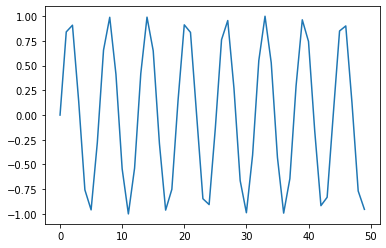

In [ ]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])

In [ ]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
X = xx
Y = yy

In [ ]:
xx[1]

'a'

In [ ]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
     # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)

Epoch:  1 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  2 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  3 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  4 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  5 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  6 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  7 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  8 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  9 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  10 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  11 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  12 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  13 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
Epoch:  14 , Loss:  [[128621.10560521]] , Val Loss:  [[64308.55683171]]
E

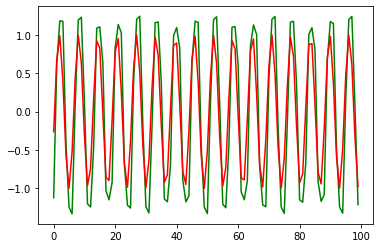

In [ ]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

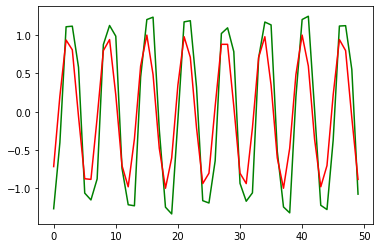

In [ ]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [ ]:
rnn = Model(word_dim, hidden_dim)

losses = rnn.train(X, Y, learning_rate=0.005, nepoch=10, evaluate_loss_after=1)

AssertionError: ignored